# Imports

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Tensorflow backend initialization

In [20]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

Amount of GPUs available: 4


# Function definitions

In [21]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def resample_df(df, sample_rate):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    """
    #if sample_rate == 'H' or '1H':
    #    return df
    
    input_df = df
    
    to_last = ['gasMeter', 'eMeter'] # resample.last(), take last known value from the columns
    
    input_df[to_last] = input_df[to_last].resample(sample_rate).last() # take last value most nearby the sample_rate
    
    input_df = input_df.resample(sample_rate).mean() # resample to rest by mean
    
    return input_df

# Preparing dataframe for preprocessing

In [22]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//P01S01W8655_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.drop(['dwelling'], axis=1)
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D') # For some reason this makes df equal h, so it changes the df variable being read in at the start...
#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['hour'] = df.index.hour #create column containing the hour
#df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

CPU times: user 219 ms, sys: 0 ns, total: 219 ms
Wall time: 213 ms


In [23]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,Q,RG,SQ,T,T10,TD,U,VV,WW,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24,NaN,0.0,736.983000,0.0,450.653377,0.0,NaN,267.907575,151.272727,4.926667,...,160.696970,0.350000,0.220361,10.819697,11.121212,6.662121,75.712122,29368.333455,29.696970,0.201372
2017-04-25,790.166,0.0,738.217500,0.0,365.682568,0.0,1597.476,285.680485,47.416667,5.478194,...,226.218744,0.080208,4.004910,6.503472,6.373403,1.977500,72.906250,36118.680500,23.550000,0.150121
2017-04-26,796.967,0.0,739.742318,0.0,376.575828,0.0,1605.915,270.914473,42.545455,3.074758,...,223.212121,0.112348,3.856208,6.132197,5.827121,2.092727,76.340910,34583.575909,12.346970,0.375732
2017-04-27,796.967,0.0,744.674917,0.0,411.699121,0.0,1611.051,233.521111,17.708333,2.968375,...,201.895833,0.023264,2.682295,6.181319,5.922500,2.129722,76.137500,36665.555917,11.267361,0.213999
2017-04-28,807.578,0.0,751.724250,0.0,511.259890,0.0,1617.091,266.770347,58.366667,2.997917,...,184.917362,0.156111,2.737647,7.958750,7.910486,4.364167,78.612500,33648.791625,18.394445,0.251663


## Get a proper hourly dataframe

Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

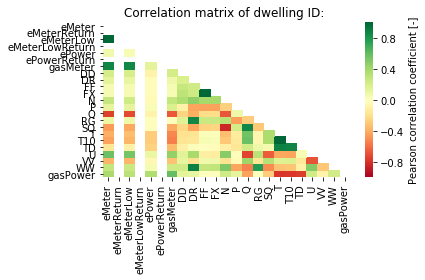

In [24]:
fig = create_corr_matrix(df, '', False)

## Select data we want

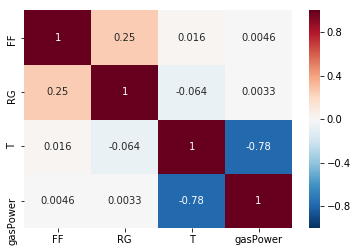

In [25]:
data = df
data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

sns.heatmap(data.corr(), annot=True)

# EDA

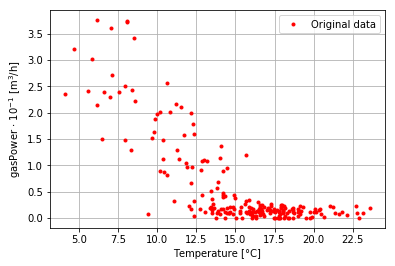

In [26]:
plt.plot(data['T'], data['gasPower'], '.', color='r', label='Original data')
plt.grid()
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()

In [27]:
#sns.pairplot(data)

# Preprocessing

In [39]:
def scale_reshape(X_train, X_test, y_train, y_test):
    """
    Input: X and y as pandas dataframes.
    Scales and reshapes X and y. 
    Output: X and y as numpy ndarrays.
    """
    
    # Scale the data
    scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
    #scalery = StandardScaler(with_mean=True, with_std=True).fit(y_train)

    # Normalize X arrrays
    X_train = scalerX.transform(X_train)
    X_test = scalerX.transform(X_test)

    # Get test data in the correct shape and format
    y_train = np.array(y_train).reshape(-1,1) #reshape if y_train is not scaled, transforming should not be needed
    y_test = np.array(y_test).reshape(-1,1)
    
    return X_train, X_test, y_train, y_test

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

seed = 42

X = data.drop(['gasPower'], axis=1)
print('X columns: %s' % list(X.columns))

#sns.heatmap(X.corr(), annot=True)

y = data[['gasPower']]

# Add history to the df
X = create_timeseries_history(X, columns_to_lookback=X.columns, n_lookback=4*7, dropnan=True)


print('X columns final: %s' % list(X.columns))

X columns: ['FF', 'RG', 'T']
X columns final: ['FF', 'RG', 'T', 'FF (t-1)', 'FF (t-2)', 'FF (t-3)', 'FF (t-4)', 'FF (t-5)', 'FF (t-6)', 'FF (t-7)', 'FF (t-8)', 'FF (t-9)', 'FF (t-10)', 'FF (t-11)', 'FF (t-12)', 'FF (t-13)', 'FF (t-14)', 'FF (t-15)', 'FF (t-16)', 'FF (t-17)', 'FF (t-18)', 'FF (t-19)', 'FF (t-20)', 'FF (t-21)', 'FF (t-22)', 'FF (t-23)', 'FF (t-24)', 'FF (t-25)', 'FF (t-26)', 'FF (t-27)', 'RG (t-1)', 'RG (t-2)', 'RG (t-3)', 'RG (t-4)', 'RG (t-5)', 'RG (t-6)', 'RG (t-7)', 'RG (t-8)', 'RG (t-9)', 'RG (t-10)', 'RG (t-11)', 'RG (t-12)', 'RG (t-13)', 'RG (t-14)', 'RG (t-15)', 'RG (t-16)', 'RG (t-17)', 'RG (t-18)', 'RG (t-19)', 'RG (t-20)', 'RG (t-21)', 'RG (t-22)', 'RG (t-23)', 'RG (t-24)', 'RG (t-25)', 'RG (t-26)', 'RG (t-27)', 'T (t-1)', 'T (t-2)', 'T (t-3)', 'T (t-4)', 'T (t-5)', 'T (t-6)', 'T (t-7)', 'T (t-8)', 'T (t-9)', 'T (t-10)', 'T (t-11)', 'T (t-12)', 'T (t-13)', 'T (t-14)', 'T (t-15)', 'T (t-16)', 'T (t-17)', 'T (t-18)', 'T (t-19)', 'T (t-20)', 'T (t-21)', 'T (t-22)

In [43]:
# Get it in the right shape
X = np.array(X).reshape(-1, len(X.columns)) # might aswell use .T to transpose instead of -1, ...
y = np.array(y).reshape(-1, len(y.columns))

# Keras

In [45]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras

In [61]:
def make_model():
    # Create model
    model = Sequential()

    activation = 'relu'
    #19
    model.add(Dense(16, input_shape=(X_train.shape[1],), kernel_initializer='normal'))
    model.add(Activation(activation))
    model.add(Dropout(0.5, seed=seed)) 

    # Dropout: 1 wont ''drop'' any data, 0.5 will drop half of the data
    # https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning-And-why-is-it-claimed-to-be-an-effective-trick-to-improve-your-network
    N = 256 #45

    for i in range(4):
        model.add(Dense(N-i*4, kernel_initializer='normal'))
        model.add(Activation(activation))
        model.add(Dropout(0.5, seed=seed))


    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Activation('linear'))
    return model


def compile_fit(model):
    # Compile and fit
    multi_model = multi_gpu_model(model, gpus=num_gpu)

    lr = 0.55
    epochs = 150
    #decay_rate = 1*10**(-8)
    decay_rate = 0
    sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

    # compiling the sequential model
    #multi_model.compile(loss='mean_squared_error', optimizer='adam')
    multi_model.compile(loss='mean_squared_error', metrics=['mse', abs_percentage_error], optimizer='adam')

    early_stopping_monitor = EarlyStopping(patience=50)

    tensorboard = TensorBoard(log_dir="/home/16011015/notebooks/logs/{}".format(time()))

    # training the model and saving metrics in history
    multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), 
                    epochs=epochs, verbose=2, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping_monitor, PlotLossesKeras(), tensorboard])
    return multi_model

# Compile and fit 

In [62]:
import keras.backend as K
def abs_percentage_error(y_true, y_pred):
    """
    Returns the absolute value of the difference between y_true and y_pred (in percentage).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

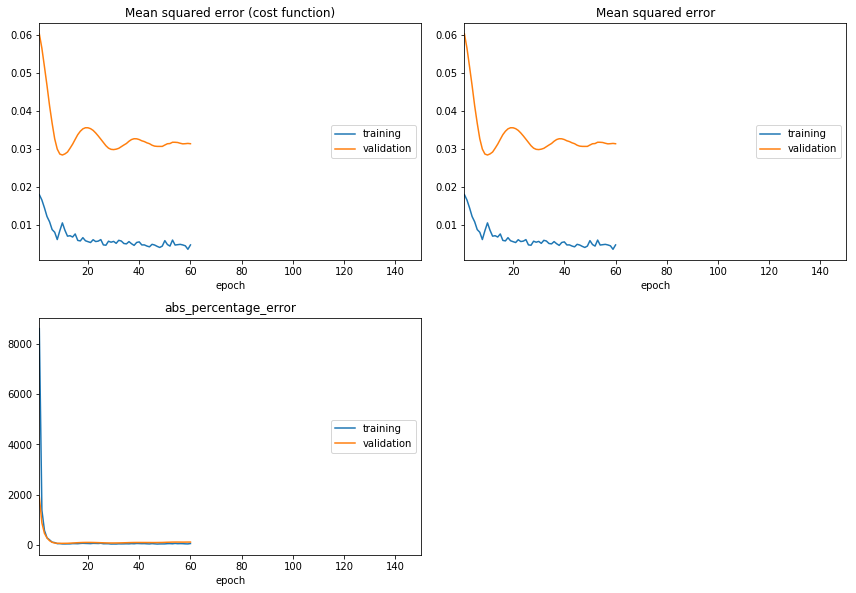

 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - abs_percentage_error: 65.9224 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_abs_percentage_error: 123.7468
7/7 [==============================] - 0s 796us/step
Train: [103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130] 	 Test: [131 132 133 134 135 136 137]


In [ ]:
scores = []
y_tests = []
y_preds = []
test_indices = []

n = 26

for train_index, test_index in TimeSeriesSplit(n_splits=n, max_train_size=4*7).split(X):
    # Train on one month, try to predict 1 week ahead, n_splits=26, max_train_size=4*7
    print("Train: %s \t Test: %s" % (train_index, test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Scale reshape
    X_train, X_test, y_train, y_test = scale_reshape(X_train, X_test, y_train, y_test)
    
    # Create the keras model
    model = make_model()
    
    # Compile and fit the model
    model = compile_fit(model)
    
    scores.append(model.evaluate(X_test, y_test))
    y_tests.append(y_test)
    y_preds.append(model.predict(X_test))
    test_indices.append(test_index)

In [16]:
# Create a dataframe containing the model scores
df_scores = pd.DataFrame(scores, columns=['loss', 'mse', 'abs percentage error'])
df_scores

,loss,mse,abs percentage error
0,0.269627,0.269627,82.742081
1,0.045310,0.045310,61.292778
2,0.143738,0.143738,91.358147
3,0.013510,0.013510,54.800266
4,0.002596,0.002596,39.426125
5,0.004682,0.004682,43.053730
6,0.005464,0.005464,64.737267
7,0.011935,0.011935,98.609047
8,0.005469,0.005469,85.218445
9,0.003376,0.003376,60.722836


FINISHED


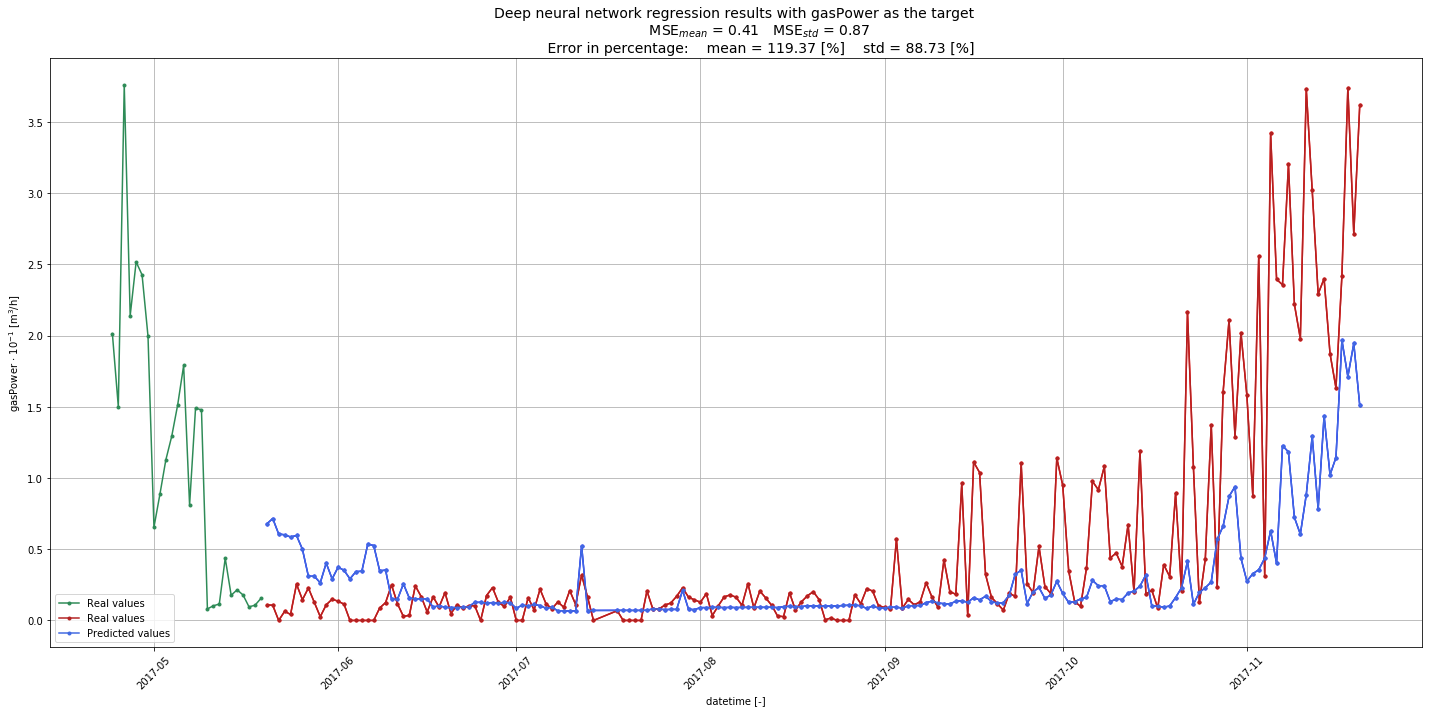

In [17]:
y_t = np.vstack(y_tests) # List of ndarrays to one ndarray
y_p = np.vstack(y_preds)

# Get the x values for y predictions
start = np.concatenate(test_indices)[0] # start y pred index
stop = np.concatenate(test_indices)[-1] # stop y pred index
x = data['datetime'][start:stop+1] # series of dates from start to stop+1

plt.figure(figsize=(20,10))
plt.plot(x, y_t, '.-', color='r')
plt.plot(x, y_p, '.-', color='b')

plt.plot(data['datetime'][:start], data['gasPower'][:start], '.-', color='seagreen', label='Real values') # shows training data
plt.plot(x, y_t, '.-', color='firebrick', label='Real values', alpha=1)
plt.plot(x, y_p, '.-', color='royalblue', label='Predicted values', alpha=1)

plt.xlabel('datetime [-]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.xticks(rotation=45)
plt.legend()
plt.grid()

mse_mean = df_scores['mse'].mean()
mse_std = df_scores['mse'].std()
percentage_mean = df_scores['abs percentage error'].mean()
percentage_std = df_scores['abs percentage error'].std()

plt.title('Deep neural network regression results with gasPower as the target \n \
          MSE$_{mean}$ = %.2f \t MSE$_{std}$ = %.2f \n \
          Error in percentage:    mean = %.2f [%%]    std = %.2f [%%]' % (mse_mean, mse_std, percentage_mean, percentage_std), fontsize = 14)
plt.tight_layout()

#plt.savefig('figures/8655 result.png', dpi=1000)
print('FINISHED')

# Plot results

In [18]:
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
FF = x_pred[:,0]
RG = x_pred[:,1]
T = x_pred[:,2]

fig, axarr = plt.subplots(2,2)


axarr[0, 0].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 0].plot(T, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(T, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

axarr[0, 1].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(RG, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[0, 1].plot(RG, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)


axarr[1, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[1, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

fig.delaxes(axarr[1, 1])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

#fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s $\cdot$ 10$^{-%s}$' % (mse_val, mse_power), fontsize = 14)
fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[1, 0].legend(loc='lower left', bbox_to_anchor= (1.25, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

x_pred scaled-> 	 shape: (7, 9) 	 var: 1.1E+00 	 mean: 1.1E-01 	 std: 1.0E+00


NameError: name 'scalerX' is not defined

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)

In [ ]:
# Complete plot, commented out
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
DD = x_pred[:,0]
FF = x_pred[:,1]
N = x_pred[:,2]
Q = x_pred[:,3]
RG = x_pred[:,4]
T = x_pred[:,5]
U = x_pred[:,6]

fig, axarr = plt.subplots(3,3)

axarr[0, 0].plot(data['DD'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[0, 0].plot(DD, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(DD, y_pred, 'x', color='b', label='X_test, y_predict', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Wind direction $DD$ [$\degree$] \n (10 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[0, 1].plot(data['N'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(N, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 1].plot(N, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Total cloud coverage $N$ [octa]')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[0, 2].plot(data['Q'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 2].plot(Q, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 2].plot(Q, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 2].grid()
axarr[0, 2].set_xlabel('global radiation $Q$ [W/m$^2$] \n (10 min mean)')
axarr[0, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 0].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 0].plot(RG, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(RG, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 1].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 1].plot(T, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[1, 1].plot(T, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[1, 1].grid()
axarr[1, 1].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[1, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 2].plot(data['U'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 2].plot(U, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 2].plot(U, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 2].grid()
axarr[1, 2].set_xlabel('Relative humidity at 1,5 m $U$ [%] \n (1 min mean)')
axarr[1, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[2, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[2, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[2, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[2, 0].grid()
axarr[2, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[2, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

fig.delaxes(axarr[2, 1])
fig.delaxes(axarr[2, 2])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()



fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[2, 0].legend(loc='lower left', bbox_to_anchor= (2, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)